In [1]:
#set adequate flag for Theano on lxplus
import theano
theano.config.gcc.cxxflags = '-march=corei7'

In [2]:
#check config
import keras.backend as K
K.set_image_dim_ordering('th')
#print 'Keras backend:', K.backend()
#print 'Keras image ordering operator: ', K.image_dim_ordering()

Using Theano backend.


In [3]:
#load needed things
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.models import Sequential, Model
from keras.optimizers import SGD
from keras.layers import Input, Activation, Dense, Convolution2D, MaxPooling2D, Dropout, Flatten
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as pyp
import ROOT
import itertools
import math

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

Welcome to JupyROOT 6.07/07


In [4]:
#shifts the subjets towards the highest pt subjet
#eta'_i = eta_i - eta_0
#phi'_i = phi_i - phi_0
def translate(x, y):
    xShift = []
    yShift = []
    
    xCenter = x[0]
    yCenter = y[0]
    for ix, iy in zip(x, y):
        xShift.append( ix - xCenter )
        yShift.append( iy - yCenter )
    
    return xShift, yShift

In [5]:
#rotation not applied directly on eta-phi plane to preserve Lorentz invariances
#the rotation is likely done around px
def rotate(x,y,w):
    #defines subjets based on reclustering the PF candidates from PF jet
    #ak4PFJetCHS->R=0.4, so I adopt the half of it
    radius = 0.2
    maxPt = -1
    v = 0
    for ix, iy, iw, in zip(x, y, w):
        dR = math.sqrt( math.pow(ix - x[0], 2) + math.pow(iy - y[0], 2) )
        pt = iw
        if dR > radius and pt > maxPt:
            maxPt = pt
            py = pt*math.sin(iy)
            pz = pt*math.sinh(ix)
            v = np.arctan2(py,pz) + np.radians(90)

    rot_x = []
    rot_y = []
    #creates a rotation matrix
    c, s = np.cos(v), np.sin(v)
    R = np.matrix('{} {}; {} {}'.format(c, -s, s, c))
    for ix, iy, iw in zip(x, y, w):
        #original components
        px = iw*math.cos(iy)
        py = iw*math.sin(iy)
        pz = iw*math.sinh(ix)

        #transforms components
        #rot = [[py.cos(v) - pz.sin(v)],
        #       [py.sin(v) + pz.cos(v)]]
        rot = R*np.matrix([[py],[pz]])
        rix, riy = np.arcsinh(rot[1,0]/iw), np.arcsin(rot[0,0]/iw)
        
        rot_x.append(rix)
        rot_y.append(riy)
        
    return rot_x, rot_y

In [6]:
#accounts for assymetry on energy distribution
#keeps the jet average pt always in eta' positive range
def reflect(x, w):
    leftSum = 0
    rightSum = 0
    for ix, iw in zip(x, w):
        if ix > 0: 
            rightSum += iw
        elif ix < 0:
            leftSum += iw
    if(leftSum > rightSum):
        ref_x = [e*(-1) for e in x]
        return ref_x
    else:
        return x

In [24]:
#according to https://arxiv.org/abs/1704.02124 returns similar calorimeter resolution
#nx size of image in eta
#ny size of image in phi
def prepareImages(inputs, nx, xmin, xmax, ny, ymin, ymax, pre_process):
    njets = len(inputs)
    print 'Njets = %i' % njets
        
    list_x = [[],[]]
    list_y = [[],[]]
    list_w = [[],[]]

    #determines the pixel of picture
    xbins = np.linspace(xmin,xmax,nx+1)
    ybins = np.linspace(ymin,ymax,ny+1)
    #creates an empty 'th2'
    jet_images = np.zeros((njets/2, 2, nx, ny))

    #group eta/phi/pt by jet
    for ijet in range(njets):        
        # relative eta
        x = inputs[ijet][0]
        # relative phi
        y = inputs[ijet][1]
        # pt of candidate is the weight
        pt = inputs[ijet][2]
        #charge
        charge = inputs[ijet][3]
        #pdgid
        pdgid = inputs[ijet][4]
        
        weights = pdgid
        #scale by maxPt in each jet
        maxPt = max(weights)
                
        #shifts the jet image to the center in (eta,phi) = (0,0)
        if(pre_process[0]):
            x, y = translate(x, y)

        #applies the rotation processing
        if(pre_process[1]):
            x, y = rotate(x, y, weights)
                        
        #applies the reflection processing
        if(pre_process[2]):
            x = reflect(x, weights)

        #applies normalization
        if(pre_process[3]):
            sumPt = sum(weights)
            nweights = []
            for iw, ich in zip(weights,charge):
                if(ich == 0):
                    nweights.append( iw/sumPt )
                else:
                    nweights.append( ich*iw/sumPt )
            weights = charge
    
        if(ijet % 2 == 0): #1st PFJet
            index = ijet-ijet/2
            list_x[0].append(x)
            list_y[0].append(y)
            list_w[0].append(weights)
            hist, xedges, yedges = np.histogram2d(x, y, weights=weights, bins=(xbins, ybins))
            for ix in range(0,nx):
                for iy in range(0,ny):
                    jet_images[index,0,ix,iy] = hist[ix,iy]

        else: #2st PFJet
            index = (ijet-1)/2
            list_x[1].append(x)
            list_y[1].append(y)
            list_w[1].append(weights)
            hist, xedges, yedges = np.histogram2d(x, y, weights=weights, bins=(xbins, ybins))
            for ix in range(0,nx):
                for iy in range(0,ny):
                    jet_images[index,1,ix,iy] = hist[ix,iy]
                                        
    return jet_images, list_x, list_y, list_w, xbins, ybins

In [8]:
#check if DR is really satisfied
def passDR(eta_i, phi_i, eta_j, phi_j):
    #R = 0.4
    dij = min(1.0/(pt_i*pt_i), 1.0/(pt_j*pt_j)) * (math.pow(eta_i-eta_j,2)+math.pow(phi_i-phi_j,2)) * (1.0/(R*R))
    #dij = math.sqrt((math.pow(eta_i-eta_j,2)+math.pow(phi_i-phi_j,2)))
    
    return dij

In [9]:
#format the inputs from TTree
# 4D tensor (theano backend)
# 1st dim is jet index
# 2nd dim is eta bin
# 3rd dim is phi bin
# 4th dim is pt value (or rgb layer, etc.)
def formatInputs(tree, nevents):
    formated_inputs = []
    for ievt, evt in enumerate(tree):
        if(nevents > 0 and ievt >= nevents):
            break
        
        #sanity check
        if(evt.SubJetEta.size() != 2):
            continue
        
        #get PFJets
        nPFJets = evt.SubJetEta.size()
        for iPFJet in range(nPFJets):
            PFJetPt = evt.PFJetPt[iPFJet]
            eta = []
            phi = []
            pt  = []
            charge = []
            pdgid = []
            
            #get daughters
            nDaughters = evt.SubJetEta[iPFJet].size()
            #1st daughter - highest pt
            subJetEta_0 = np.mean(evt.SubJetEta[iPFJet])
            subJetPhi_0 = np.mean(evt.SubJetPhi[iPFJet])
            for iDau in range(nDaughters):
                isubJetPt = evt.SubJetPt[iPFJet][iDau]
                if(isubJetPt < 0.05*PFJetPt):
                    continue
                isubJetEta = evt.SubJetEta[iPFJet][iDau]
                isubJetPhi = evt.SubJetPhi[iPFJet][iDau]
                isubJetCharge = evt.SubJetCharge[iPFJet][iDau]
                isubJetPDGID = evt.SubJetPDGID[iPFJet][iDau]
                #dr = passDR(subJetEta_0, subJetPhi_0, isubJetEta, isubJetPhi)
                #print 'jpf: %i, sbj: %i, dr: %.3f' % (iPFJet,iDau,dr)
                #if( dr < 0.5 ):
                eta.append( isubJetEta )
                phi.append( isubJetPhi )
                pt.append( isubJetPt )
                charge.append( isubJetCharge )
                pdgid.append( isubJetPDGID )
            #if(len(eta) > 0):
            event = []
            event.append( eta )
            event.append( phi )
            event.append( pt )
            event.append( charge )
            event.append( pdgid )
            formated_inputs.append( event )
                
    return formated_inputs

In [30]:
#loads input data
vbf_inputs = ROOT.TFile.Open('/afs/cern.ch/work/m/mmelodea/private/MonoHiggs/CMSSW_9_0_0/src/JetImageFiles/VBF_HToZZTo4L_M125_13TeV_powheg2_JHUgenV6_pythia8.root')
vbf_tree = vbf_inputs.Get("JetImage")
vbf_events = vbf_tree.GetEntries()
print 'vbf_entries = %i' % vbf_events

ggh_inputs = ROOT.TFile.Open('/afs/cern.ch/work/m/mmelodea/private/MonoHiggs/CMSSW_9_0_0/src/JetImageFiles/GluGluHToZZTo4L_M125_13TeV_powheg2_JHUgenV6_pythia8.root')
ggh_tree = ggh_inputs.Get("JetImage")
ggh_events = ggh_tree.GetEntries()
print 'ggh_entries = %i' % ggh_events

max_events = -1
if(vbf_events < ggh_events):
    max_events = vbf_events
else:
    max_events = ggh_events
    
#max_events = 2000
#format tree inputs to adequate shape
vbf_finputs = formatInputs(vbf_tree, max_events)
ggh_finputs = formatInputs(ggh_tree, max_events)
print 'Jets on vbf input: %i' % (len(vbf_finputs))
print 'Jets on ggh input: %i' % (len(ggh_finputs))


#print '-------- Showing and event example -------'
#print formated_inputs[0]

vbf_entries = 12706
ggh_entries = 13105
Jets on vbf input: 25412
Jets on ggh input: 25412


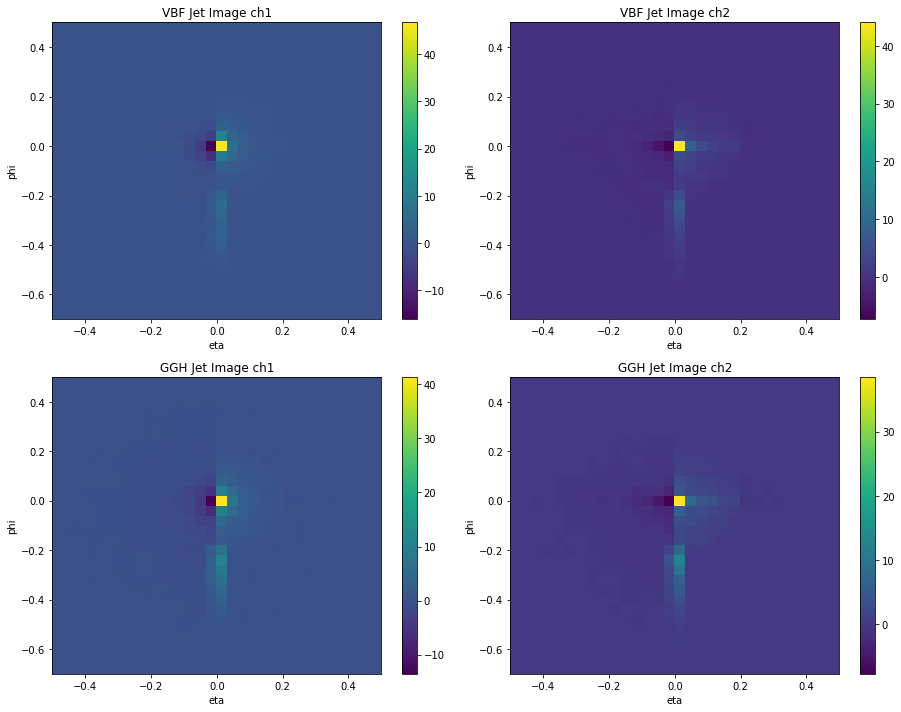

Njets = 25412
Njets = 25412


In [31]:
#defines pixels
nx = 30
ny = 30
proc = [True,True,True,False]

#create and show jet images
vbf_jet_images, vbf_list_x, vbf_list_y, vbf_list_w, vbf_xbins, vbf_ybins = prepareImages(vbf_finputs, nx, -0.5, 0.5, ny, -0.7, 0.5, proc)

c1_vbf_all_x = np.concatenate(vbf_list_x[0])
c1_vbf_all_y = np.concatenate(vbf_list_y[0])
c1_vbf_all_w = np.concatenate(vbf_list_w[0])
c1_vbf_all_w = 1.*c1_vbf_all_w/len(vbf_jet_images) # to get average

c2_vbf_all_x = np.concatenate(vbf_list_x[1])
c2_vbf_all_y = np.concatenate(vbf_list_y[1])
c2_vbf_all_w = np.concatenate(vbf_list_w[1])
c2_vbf_all_w = 1.*c2_vbf_all_w/len(vbf_jet_images) # to get average

ggh_jet_images, ggh_list_x, ggh_list_y, ggh_list_w, ggh_xbins, ggh_ybins = prepareImages(ggh_finputs, nx, -0.5, 0.5, ny, -0.7, 0.5, proc)

c1_ggh_all_x = np.concatenate(ggh_list_x[0])
c1_ggh_all_y = np.concatenate(ggh_list_y[0])
c1_ggh_all_w = np.concatenate(ggh_list_w[0])
c1_ggh_all_w = 1.*c1_ggh_all_w/len(ggh_jet_images) # to get average

c2_ggh_all_x = np.concatenate(ggh_list_x[1])
c2_ggh_all_y = np.concatenate(ggh_list_y[1])
c2_ggh_all_w = np.concatenate(ggh_list_w[1])
c2_ggh_all_w = 1.*c2_ggh_all_w/len(ggh_jet_images) # to get average

fig = pyp.figure()
fig.set_figheight(10)
fig.set_figwidth(13)

fig1 = fig.add_subplot(221)
fig1 = pyp.hist2d(c1_vbf_all_x, c1_vbf_all_y, weights=c1_vbf_all_w, bins=(vbf_xbins,vbf_ybins))#, norm=mpl.colors.LogNorm())
fig1 = pyp.colorbar()
fig1 = pyp.xlabel('eta')
fig1 = pyp.ylabel('phi')
fig1 = pyp.title('VBF Jet Image ch1')

fig2 = fig.add_subplot(222)
fig2 = pyp.hist2d(c2_vbf_all_x, c2_vbf_all_y, weights=c2_vbf_all_w, bins=(vbf_xbins,vbf_ybins))#, norm=mpl.colors.LogNorm())
fig2 = pyp.colorbar()
fig2 = pyp.xlabel('eta')
fig2 = pyp.ylabel('phi')
fig2 = pyp.title('VBF Jet Image ch2')

fig3 = fig.add_subplot(223)
fig3 = pyp.hist2d(c1_ggh_all_x, c1_ggh_all_y, weights=c1_ggh_all_w, bins=(ggh_xbins,ggh_ybins))#, norm=mpl.colors.LogNorm())
fig3 = pyp.colorbar()
fig3 = pyp.xlabel('eta')
fig3 = pyp.ylabel('phi')
fig3 = pyp.title('GGH Jet Image ch1')

fig4 = fig.add_subplot(224)
fig4 = pyp.hist2d(c2_ggh_all_x, c2_ggh_all_y, weights=c2_ggh_all_w, bins=(ggh_xbins,ggh_ybins))#, norm=mpl.colors.LogNorm())
fig4 = pyp.colorbar()
fig4 = pyp.xlabel('eta')
fig4 = pyp.ylabel('phi')
fig4 = pyp.title('GGH Jet Image ch2')

pyp.tight_layout()
fig = pyp.show()

In [32]:
# Model
def build_conv_model():
    input_layer = Input(shape=(2, nx, ny))
    layer = Convolution2D(8, (4, 4), padding='same')(input_layer)
    layer = Activation('relu')(layer)
    layer = MaxPooling2D(pool_size=(2,2))(layer)
    layer = Convolution2D(8, (4, 4), padding='same')(layer)
    layer = Activation('relu')(layer)
    layer = MaxPooling2D(pool_size=(2,2))(layer)
    layer = Convolution2D(8, (2, 2), padding='same')(layer)
    layer = Activation('relu')(layer)
    layer = MaxPooling2D(pool_size=(2,2))(layer)
    layer = Flatten()(layer)
    layer = Dropout(0.20)(layer)
    layer = Dense(30)(layer)
    layer = Dropout(0.10)(layer)
    output_layer = Dense(1, activation='sigmoid')(layer)
    model = Model(input=input_layer, output=output_layer)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

conv_model = build_conv_model()
conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 2, 30, 30)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 8, 30, 30)         264       
_________________________________________________________________
activation_21 (Activation)   (None, 8, 30, 30)         0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 8, 15, 15)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 8, 15, 15)         1032      
_________________________________________________________________
activation_22 (Activation)   (None, 8, 15, 15)         0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 8, 7, 7)           0         
__________

/afs/cern.ch/user/m/mmelodea/keras/lib/python2.7/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=sigmoid.0, inputs=/input_8)`


In [33]:
#prepare inputs for model
X = np.concatenate([vbf_jet_images, ggh_jet_images])
Y_vbf = np.ones(vbf_jet_images.shape[0])
Y_ggh = np.zeros(ggh_jet_images.shape[0])
Y = np.concatenate([Y_vbf, Y_ggh])

encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

kfold = StratifiedKFold(n_splits=2, shuffle=True,  random_state=seed)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

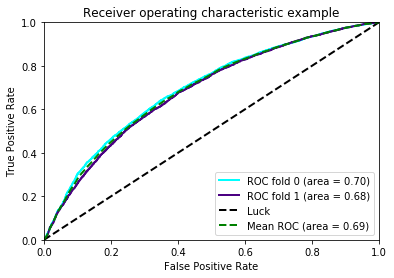

Train on 12706 samples, validate on 12706 samples
Epoch 1/10
12706/12706 [==============================] - 40s - loss: 1.9432 - acc: 0.5464 - val_loss: 0.6856 - val_acc: 0.5966
Epoch 2/10
12706/12706 [==============================] - 40s - loss: 0.7049 - acc: 0.5810 - val_loss: 0.6606 - val_acc: 0.6144
Epoch 3/10
12706/12706 [==============================] - 38s - loss: 0.6741 - acc: 0.5944 - val_loss: 0.6550 - val_acc: 0.6241
Epoch 4/10
12706/12706 [==============================] - 38s - loss: 0.6665 - acc: 0.6064 - val_loss: 0.6510 - val_acc: 0.6310
Epoch 5/10
12706/12706 [==============================] - 39s - loss: 0.6572 - acc: 0.6212 - val_loss: 0.6479 - val_acc: 0.6299
Epoch 6/10
12706/12706 [==============================] - 39s - loss: 0.6533 - acc: 0.6255 - val_loss: 0.6448 - val_acc: 0.6307
Epoch 7/10
12706/12706 [==============================] - 38s - loss: 0.6503 - acc: 0.6245 - val_loss: 0.6405 - val_acc: 0.6404
Epoch 8/10
12706/12706 [==============================

/afs/cern.ch/user/m/mmelodea/keras/lib/python2.7/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=sigmoid.0, inputs=/input_9)`
/afs/cern.ch/user/m/mmelodea/keras/lib/python2.7/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=sigmoid.0, inputs=/input_10)`


In [34]:
# Train and plot ROC curves
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from scipy import interp

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange', 'red', 'black', 'green', 'brown'])
lw = 2

i = 0
histories = []
for (train, test), color in zip(kfold.split(X, encoded_Y), colors):
    conv_model = build_conv_model()
    history = conv_model.fit(X[train], encoded_Y[train], validation_data=(X[test], encoded_Y[test]), epochs=10, batch_size=128, verbose=1, callbacks=[early_stopping])
    Y_score = conv_model.predict(X[test])
    histories.append(history)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(encoded_Y[test], Y_score)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    pyp.plot(fpr, tpr, lw=lw, color=color, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    i += 1
pyp.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k', label='Luck')
mean_tpr /= kfold.get_n_splits(X, encoded_Y)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
pyp.plot(mean_fpr, mean_tpr, color='g', linestyle='--',label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)
pyp.xlim([0, 1.0])
pyp.ylim([0, 1.0])
pyp.xlabel('False Positive Rate')
pyp.ylabel('True Positive Rate')
pyp.title('Receiver operating characteristic example')
pyp.legend(loc="lower right")
pyp.show()

In [ ]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    #x *= 255
    if K.image_dim_ordering()=='tf':
        x = x.transpose((1, 2, 0))
        x = x.transpose((1, 0, 2))
    #x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
# dimensions of the generated pictures for each filter.
img_width = nx
img_height = ny

layer_dict = dict([(layer.name, layer) for layer in conv_model.layers])
input_img = conv_model.input

pics = {}
num_filters = {}
for key, layer in layer_dict.iteritems():
    #if 'convolution2d' in key:
    if 'conv2d' in key:
        num_filters[key] = 8
        
layer_name = num_filters.keys()[2]

print num_filters.keys()
print layer_name # here we pick which layer to visualize

In [ ]:
kept_filters = []
for filter_index in range(0,num_filters[layer_name]):
    # build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
    if K.image_dim_ordering()=='tf':
        loss = K.mean(layer_output[:, filter_index, :, :])
    else:
        loss = K.mean(layer_output[:, :, :, filter_index])

    # compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # step size for gradient ascent
    step = 1.

    # we start from a gray image with some random noise
    
    if K.image_dim_ordering()=='tf':
        input_img_data = np.random.random((1, img_width, img_height, 1))
    else:
        input_img_data = np.random.random((1, 1, img_width, img_height))
        
    input_img_data = (input_img_data - 0.5) * 20 + 128

    # we run gradient ascent for 100 steps
    for i in range(100):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

    # decode the resulting input image
    img = deprocess_image(input_img_data[0])
    kept_filters.append((img, loss_value))
    
fig = pyp.figure(figsize=(15,15))
i = 0
j = 0
for img, loss  in kept_filters:
    i+=1
    fig.add_subplot(3,3,i)
    pyp.imshow(img[0])
    #pyp.colorbar()
    
pyp.tight_layout()
fig = pyp.show()